In [1]:
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, utils
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
import matplotlib as mpl
import os, sys, tarfile, time, logging

In [2]:
batch_size = 64
latent_z_size = 100

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = .00002
beta1 = 0.5

data_path = 'lfw_dataset'
context = mx.gpu()

In [3]:
with tarfile.open('lfw-deepfunneled.tgz') as tar:
        tar.extractall(path=data_path)

In [4]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1] --- 흑백의 경우는....
    # 
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


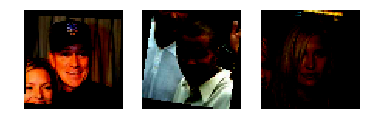

In [8]:
def  visualize(img_arr):
    #plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.imshow(img_arr.asnumpy().transpose(1, 2, 0))
    plt.axis('off')

for i, j in enumerate(np.random.choice(range(100), 3)):
    plt.subplot(1,3,i+1)
    visualize(img_list[j + 10][0])
plt.show()

In [ ]:
img_list[0]

In [9]:
ngf = 64
nc = 3
latent_dim = 100
class Gen(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Gen, self).__init__(**kwargs)
        with self.name_scope():
            #self.dense = nn.Dense(ngf*4*1024)
            # input shape : 100 * 1 * 1
            self.convT1 = nn.Conv2DTranspose(ngf * 8, kernel_size = 4, strides = 1, padding = 0, use_bias = False)
            # (ngf * 8) * 4 * 4 image
            self.convT2 = nn.Conv2DTranspose(ngf * 4, kernel_size = 4, strides = 2, padding = 1, use_bias = False)
            # (ngf * 4) * 8 * 8 image
            self.convT3 = nn.Conv2DTranspose(ngf * 2, kernel_size = 4, strides = 2, padding = 1, use_bias = False)
            # (ngf * 2) * 16 * 16 image
            self.convT4 = nn.Conv2DTranspose(ngf, kernel_size = 4, strides = 2, padding= 1, use_bias = False)
            # (ngf) * 32 * 32 image
            # 3 * 64 * 64
            self.convT5 = nn.Conv2DTranspose(nc, kernel_size = 4, strides = 2, padding= 1, use_bias = False)
            
            self.bn1 = nn.BatchNorm()
            self.bn2 = nn.BatchNorm()
            self.bn3 = nn.BatchNorm()
            self.bn4 = nn.BatchNorm()            
            
    def hybrid_forward(self, F, x):
        #x = self.dense(x)
        #x = nd.reshape(x, (-1, 1024, 4, 4))
        #print('x0.shape = {}'.format(x.shape))
        x = self.convT1(x)
        x = self.bn1(x)
        x = nd.relu(x)
        #print('x1.shape = {}'.format(x.shape))
        x = self.convT2(x)
        x = self.bn2(x)
        x = nd.relu(x)
        #print('x2.shape = {}'.format(x.shape))
        x = self.convT3(x)
        x = self.bn3(x)
        x = nd.relu(x)
        #print('x3.shape = {}'.format(x.shape))
        x = self.convT4(x)
        x = self.bn4(x)
        x = nd.relu(x)
        #print('x4.shape = {}'.format(x.shape))
        x = self.convT5(x)
        x = nd.tanh(x)
        #print('x5.shape = {}'.format(x.shape))
        return x

In [ ]:
# Check dimension
z = nd.random.uniform(shape = (64, 100, 1, 1), ctx = context)
gen = Gen()
gen.collect_params().initialize(mx.init.Xavier(), ctx = context)
a = gen(z)

In [8]:
class Disc(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Disc, self).__init__(**kwargs)
        with self.name_scope():
            self.conv1 = nn.Conv2D(128, kernel_size = 5, strides = 2, padding = 2)
            self.conv2 = nn.Conv2D(256, kernel_size = 5, strides = 2, padding = 2)
            self.conv3 = nn.Conv2D(512, kernel_size = 5, strides = 2, padding = 2)
            self.dense = nn.Dense(1, activation = 'sigmoid')
            
    def hybrid_forward(self, F, x):
        x = self.conv1(x)
        x = F.LeakyReLU(x)
        x = self.conv2(x)
        x = F.LeakyReLU(x)
        x = self.conv3(x)
        x = F.LeakyReLU(x)
        x = nd.Flatten(x)
        x = self.dense(x)
        return x

In [19]:
#z = nd.random.uniform(shape = (64, 100), ctx = mx.gpu())
#im = nd.random.uniform(shape = (20, 3, 64, 64), ctx = mx.gpu())
gen = Gen()
disc = Disc()
gen.collect_params().initialize(mx.init.Normal(0.02), ctx = context)
disc.collect_params().initialize(mx.init.Normal(0.02), ctx = context)

In [20]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
gen_trainer = gluon.Trainer(gen.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
disc_trainer = gluon.Trainer(disc.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [21]:
#define loss metric
real_label = nd.ones((batch_size,), ctx=context)
fake_label = nd.zeros((batch_size,),ctx=context)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    #print('aaaaa = {}'.format(((pred > 0.5) == label)*1.))
    corr = ((pred > 0.5) == label)*1.
    #print('corr = {}'.format(corr.mean()))
    return (((pred > 0.5) == label)*1.).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
INFO:root:speed: 301.13461822281283 samples/s
INFO:root:discriminator loss = 1.019524, generator loss = 0.690944, binary training acc = 0.991319 at epoch 0


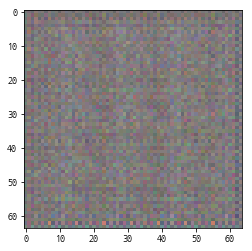

INFO:root:speed: 302.0351473102263 samples/s
INFO:root:discriminator loss = 1.012607, generator loss = 0.692370, binary training acc = 0.999283 at epoch 1


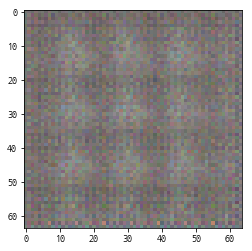

INFO:root:speed: 302.94686751838395 samples/s
INFO:root:discriminator loss = 1.009686, generator loss = 0.692505, binary training acc = 0.999736 at epoch 2


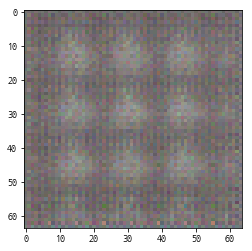

INFO:root:speed: 302.45455024055434 samples/s
INFO:root:discriminator loss = 1.007442, generator loss = 0.692942, binary training acc = 0.999925 at epoch 3


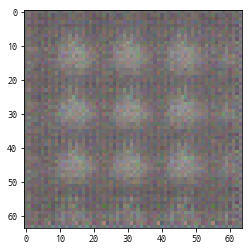

INFO:root:speed: 303.7933738745155 samples/s
INFO:root:discriminator loss = 1.006762, generator loss = 0.693080, binary training acc = 0.999962 at epoch 4


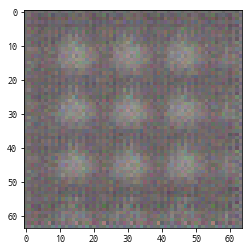

INFO:root:speed: 303.61139726984504 samples/s
INFO:root:discriminator loss = 1.006548, generator loss = 0.693114, binary training acc = 1.000000 at epoch 5


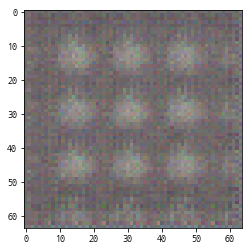

INFO:root:speed: 302.67571662937104 samples/s
INFO:root:discriminator loss = 1.006476, generator loss = 0.693126, binary training acc = 1.000000 at epoch 6


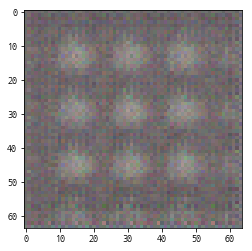

INFO:root:speed: 303.08955290361257 samples/s
INFO:root:discriminator loss = 1.006447, generator loss = 0.693132, binary training acc = 1.000000 at epoch 7


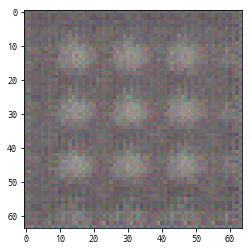

INFO:root:speed: 302.5989127149401 samples/s
INFO:root:discriminator loss = 1.006433, generator loss = 0.693135, binary training acc = 1.000000 at epoch 8


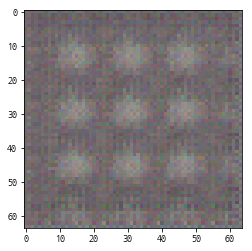

INFO:root:speed: 305.49559439193393 samples/s
INFO:root:discriminator loss = 1.006426, generator loss = 0.693138, binary training acc = 1.000000 at epoch 9


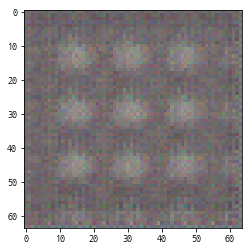

INFO:root:speed: 303.72859223041627 samples/s
INFO:root:discriminator loss = 1.006421, generator loss = 0.693139, binary training acc = 1.000000 at epoch 10


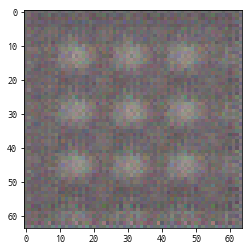

INFO:root:speed: 309.66076060530276 samples/s
INFO:root:discriminator loss = 1.006419, generator loss = 0.693141, binary training acc = 1.000000 at epoch 11


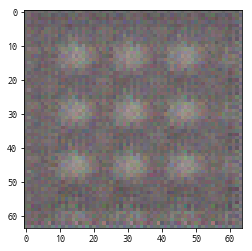

INFO:root:speed: 324.5344097979032 samples/s
INFO:root:discriminator loss = 1.006417, generator loss = 0.693141, binary training acc = 1.000000 at epoch 12


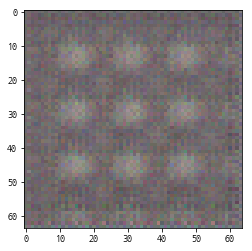

INFO:root:speed: 320.73612856232677 samples/s
INFO:root:discriminator loss = 1.006415, generator loss = 0.693142, binary training acc = 1.000000 at epoch 13


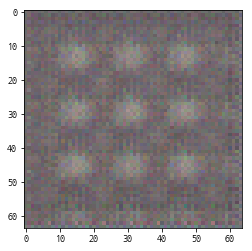

INFO:root:speed: 320.53091332235584 samples/s
INFO:root:discriminator loss = 1.006414, generator loss = 0.693143, binary training acc = 1.000000 at epoch 14


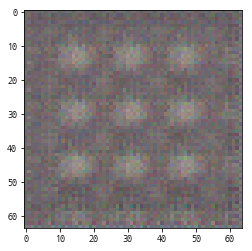

INFO:root:speed: 320.0612285743446 samples/s
INFO:root:discriminator loss = 1.006413, generator loss = 0.693143, binary training acc = 1.000000 at epoch 15


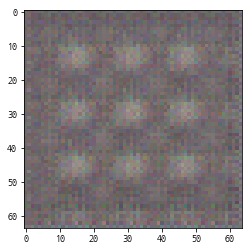

In [ ]:
%matplotlib inline

latent_z_size = 100
epochs = 20
disc_study_rate = 1
log_freq = 1

iter_loss = dict()
iter_loss['disc'] = []
iter_loss['gen'] = []


for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    n_data = 0
    for batch in train_data:
        ## Discriminator error
        data = batch.data[0].as_in_context(context)
        latent_z = nd.random.normal(0, 1, shape =(batch_size, latent_z_size, 1, 1), ctx = context)
        
        if epoch % disc_study_rate == 0:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            with autograd.record():
                # real error
                out = disc(data).reshape((-1, 1))
                d_err_real = loss(out, real_label)
                metric.update([real_label,], [out,])
                # fake error
                fake = gen(latent_z)
                fake_out = disc(fake.detach()).reshape((-1, 1)) # Generator 고정시키기
                d_err_fake = loss(fake_out, fake_label)
                d_err = d_err_real + d_err_fake
                d_err.backward()
                metric.update([fake_label,], [fake_out,])
                #print('d_err = {}'.format(d_err))
            disc_trainer.step(batch.data[0].shape[0])

        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = gen(latent_z)
            out = disc(fake).reshape((-1, 1))
            g_err = loss(out, real_label)
            g_err.backward()

        gen_trainer.step(batch.data[0].shape[0])
        n_data += data.shape[0]
        
    #save dis/gen loss
    if epoch % log_freq == 0:
        name, acc = metric.get()
        logging.info('speed: {} samples/s'.format(n_data / (time.time() - btic)))
        logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at epoch %d'
                            %(nd.mean(d_err).asscalar(),
                            nd.mean(g_err).asscalar(), acc, epoch))
        iter_loss['disc'].append(nd.mean(d_err).asscalar())
        iter_loss['gen'].append(nd.mean(g_err).asscalar())
        z = nd.random.uniform(shape = (1, latent_z_size, 1, 1), ctx = ctx)
        gen_img = gen(z)
        #print('z shape = {}'.format(gen_img.shape))
        plt.imshow(((np.squeeze(gen_img.asnumpy(), axis = 0).transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8)) #Needs to be in row,col order
        #plt.savefig('../output/gan_{}.png'.format(epoch))
        plt.show()
        
    name, acc = metric.get()
    metric.reset()

In [13]:
import os
os.getcwd()

'/home/kion/work/stat_analysis/GAN/notebooks'

In [14]:
!mkdir /home/kion/work/stat_analysis/GAN/output

## MNIST Datasety

In [10]:
import mxnet as mx
mnist = mx.test_utils.get_mnist()

/opt/venv/lib/python3.6/site-packages/mxnet/test_utils.py:1431: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(flbl.read(), dtype=np.int8)
/opt/venv/lib/python3.6/site-packages/mxnet/test_utils.py:1434: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)


In [24]:
class Gen(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Gen, self).__init__(**kwargs)
        with self.name_scope():
            #self.dense = nn.Dense(4*4*1024)
            self.convT1 = nn.Conv2DTranspose(512, kernel_size = 5, strides = 1, use_bias = False)
            self.convT2 = nn.Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 1, use_bias = False)
            self.convT3 = nn.Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 1, use_bias = False)
            self.convT4 = nn.Conv2DTranspose(3, kernel_size = 4, strides = 2, padding= 1, use_bias = False)
            
            self.bn1 = nn.BatchNorm()
            self.bn2 = nn.BatchNorm()
            self.bn3 = nn.BatchNorm()
            self.bn4 = nn.BatchNorm()            
            
    def hybrid_forward(self, F, x):
        #x = self.dense(x)
        #x = nd.reshape(x, (-1, 1024, 4, 4))
        #print('x0.shape = {}'.format(x.shape))
        x = self.convT1(x)
        x = self.bn1(x)
        x = nd.relu(x)
        print('x1.shape = {}'.format(x.shape))
        x = self.convT2(x)
        x = self.bn2(x)
        x = nd.relu(x)
        print('x2.shape = {}'.format(x.shape))
        x = self.convT3(x)
        x = self.bn3(x)
        x = nd.relu(x)
        print('x3.shape = {}'.format(x.shape))
        x = self.convT4(x)
        x = self.bn4(x)
        print('x4.shape = {}'.format(x.shape))
        return x